In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.utils.data
import torchvision
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from icecream import ic
from collections import Counter
import sys

### Load data

In [3]:
path = r"Data/final"
image_addr_list = os.listdir(path)
ic(len(image_addr_list))
data = []
img_num = []
for i in tqdm(image_addr_list):
    full_path = os.path.join(path, i)
    imgobj = Image.open(full_path).convert('L')
    img = np.asarray(imgobj)
    data.append(img)
    img_num.append(i) # Not very useful but good for debugging

ic| len(image_addr_list): 4046


  0%|          | 0/4046 [00:00<?, ?it/s]

By double-checking, images are actually binary images with value 255 or 0.

In [4]:
data = np.array(data)
ic(data.shape)
ic(np.unique(data))

ic| data.shape: (4046, 250, 730)
ic| np.unique(data): array([  0, 255], dtype=uint8)


array([  0, 255], dtype=uint8)

In [5]:
# 0: black; 1: white (make most of the pixel to be zero (nonactivation) can probably increase performance)
data = torch.tensor(1 - (data / 255), dtype=torch.float32).unsqueeze(1)

In [6]:
ic(data.shape)

ic| data.shape: torch.Size([4046, 1, 250, 730])


torch.Size([4046, 1, 250, 730])

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fcd59942be0>)

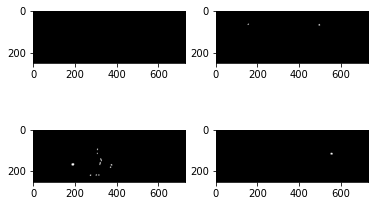

In [7]:
plt.subplot(2,2,1), plt.imshow(data[0].squeeze(), 'gray')
plt.subplot(2,2,2), plt.imshow(data[1].squeeze(), 'gray')
plt.subplot(2,2,3), plt.imshow(data[2].squeeze(), 'gray')
plt.subplot(2,2,4), plt.imshow(data[3].squeeze(), 'gray')

### Load labels
0 -> Good

1 -> Defects

By observation, only 1895 images out of 4046 CT scans are with defects.

In [8]:
label = torch.load("Data/label/label.pt")
ic(label.unique())
ic(label.sum()) # there are only 1895 images with defects
# ic(label[0:20])
# Example
# assert (data[0] - data[4]).sum() == 0

ic| label.unique(): tensor([0, 1])
ic| label.sum(): tensor(1895)


tensor(1895)

In [9]:
from models.img_autoencoder import *

In [10]:
model = AutoEncoder(6)
summary(model, input_size=data[0:10].shape)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [10, 1, 250, 730]         --
├─Encoder: 1-1                           [10, 6]                   --
│    └─Conv2d: 2-1                       [10, 16, 250, 730]        800
│    └─MaxPool2d: 2-2                    [10, 16, 83, 243]         --
│    └─Conv2d: 2-3                       [10, 8, 83, 243]          6,280
│    └─MaxPool2d: 2-4                    [10, 8, 27, 81]           --
│    └─Flatten: 2-5                      [10, 17496]               --
│    └─Linear: 2-6                       [10, 2560]                44,792,320
│    └─Linear: 2-7                       [10, 128]                 327,808
│    └─Linear: 2-8                       [10, 64]                  8,256
│    └─Linear: 2-9                       [10, 6]                   390
├─Decoder: 1-2                           [10, 1, 250, 730]         --
│    └─Linear: 2-10                      [10, 64]               

ic| defects_data.shape: torch.Size([1895, 1, 250, 730])
ic| non_def_data.shape: torch.Size([2151, 1, 250, 730])


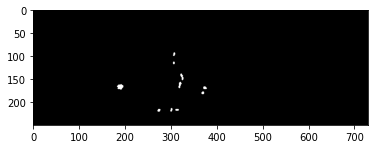

In [21]:
defects_data = data[label == 1]
non_def_data = data[label == 0]
ic(defects_data.shape)
ic(non_def_data.shape)
# Example
plt.imshow(defects_data[1].squeeze(), 'gray')

In [24]:
from sklearn.model_selection import train_test_split
num_non_defect = 100
full_data = torch.cat([defects_data, non_def_data[0:num_non_defect]])
ic(full_data.shape)
tri_set, val_set= train_test_split(full_data, test_size=0.1, random_state=2022)
ic(tri_set.shape)
ic(val_set.shape)

ic| full_data.shape: torch.Size([1995, 1, 250, 730])
ic| tri_set.shape: torch.Size([1795, 1, 250, 730])
ic| val_set.shape: torch.Size([200, 1, 250, 730])


torch.Size([200, 1, 250, 730])

In [23]:
bs = 32
tri_ldr = torch.utils.data.DataLoader(tri_set, batch_size=bs,shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_set, batch_size=bs,shuffle=True)